In [1]:
import pandas as pd
import numpy as np
import os
import pythermalcomfort
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from datetime import timedelta
from matplotlib.ticker import FuncFormatter

In [2]:
filteredCompleteData = pd.read_csv('../data/comfort/filteredCompleteData.csv', index_col=0, parse_dates=True)

In [3]:
# define color pallete for plots

c0 = np.array([[0.6078, 0.6941, 0.9412, 1.],
              [0.7216, 0.8588, 0.9765, 1.],
              [0.8588, 0.9333, 0.9882, 1.],
              [0.8745, 0.9137, 0.8078, 1.],
              [0.9725, 0.8471, 0.8706, 1.],
              [0.97, 0.72, 0.62, 1.],
              [0.85, 0.42, 0.43, 1.]]) # thermal sensation, updated color

c1 = np.array([[0.3569, 0.6078, 0.8353, 1.],
              [0.7412, 0.8431, 0.9333, 1.],
              [0.9725, 0.7961, 0.6784, 1.],
              [0.9294, 0.4902, 0.1922, 1.]]) # thermal acceptability

c2 = np.array([[0.3569, 0.6314, 0.8235, 1.],
              [0.92, 0.92, 0.92, 1.],
              [0.9961, 0.5725, 0.3333, 1.]]) # thermal preference, updated color

c3 = np.array([[0., 0.4196, 0.1098, 1.],
              [0.4157, 0.7059, 0.4039, 1.],
              [0.7647, 0.8549, 0.6824, 1.],
              [0.92, 0.92, 0.92, 1.],
              [0.9, 0.784, 0.81, 1.],
              [0.87, 0.4672, 0.3651, 0.8],
              [0.7415, 0.3565, 0.3672, 1.]]) # thermal satisfaction

## overview the testing conditions 
the filterd dataset consists all the subjective measurements and the in-situ environmental measurements.
as some participants opted bi-weekly survey, we presents data in bi-weekly resolution.

C:\Users\bdgleiy.NUSSTF\AppData\Local\Temp\ipykernel_29320\1995065607.py:11: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.scatterplot(data=filteredCompleteData, x="Temperature", y="Air Speed", hue="TAV",


Text(0, 0.5, 'Air Speed (m/s)')

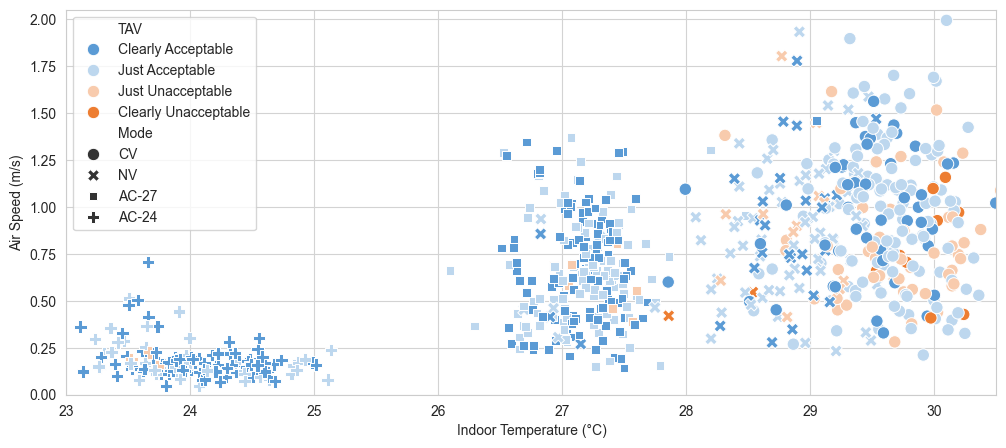

In [4]:
# Set the style for the background color
sns.set_style("whitegrid", {
    'axes.facecolor': 'white',  # Set the background to white
    'grid.color': 'lightgrey'   # Set the grid color to light grey
})

plt.figure(figsize=(12, 5))

plt.xlim(23, 30.5)
plt.ylim(0, 2.05)
sns.scatterplot(data=filteredCompleteData, x="Temperature", y="Air Speed", hue="TAV", 
                hue_order=['Clearly Acceptable','Just Acceptable','Just Unacceptable','Clearly Unacceptable'], 
                style="Mode", style_order=['CV','NV','AC-27','AC-24'], palette=c1, s=80)

plt.legend(loc='upper left', frameon=True)
plt.xlabel("Indoor Temperature (°C)")
plt.ylabel("Air Speed (m/s)")

C:\Users\bdgleiy.NUSSTF\AppData\Local\Temp\ipykernel_29320\2417943290.py:4: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.scatterplot(data=filteredCompleteData, x="Temperature", y="Air Speed", hue="TSV",


Text(0, 0.5, 'Air Speed (m/s)')

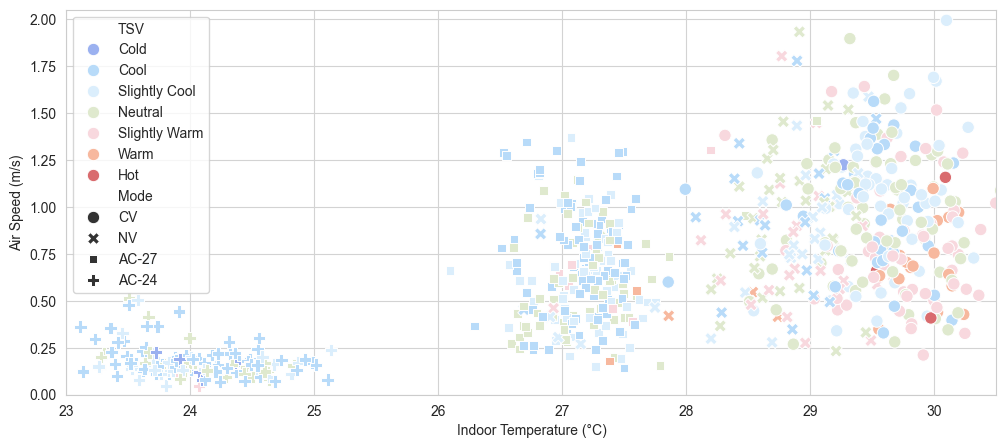

In [5]:
plt.figure(figsize=(12, 5))
plt.xlim(23, 30.5)
plt.ylim(0, 2.05)
sns.scatterplot(data=filteredCompleteData, x="Temperature", y="Air Speed", hue="TSV", 
                hue_order=['Cold','Cool','Slightly Cool','Neutral','Slightly Warm','Warm','Hot'],
                style="Mode", style_order=['CV','NV','AC-27','AC-24'], palette=c0, s=80)

plt.legend(loc='upper left', frameon=True)
plt.xlabel("Indoor Temperature (°C)")
plt.ylabel("Air Speed (m/s)")

## IEQ (indoor environmental quality) by operational mode

In [6]:
# subjective measurement plots
# prepare data in the mode order
def dataPrepare(rawData, vote, voteOrder, modeOrder):
    data = rawData[['Mode', vote]]
    cross_tab_perc = pd.crosstab(index=data['Mode'],
                                 columns=data[vote],
                                 normalize="index")
    # deal with missing category in a small sample, fill with zeros
    for col in voteOrder:
        if col in cross_tab_perc: continue
        else: cross_tab_perc[col] = 0.
    # change the column and index orders
    cross_tab_perc = cross_tab_perc[voteOrder].reindex(modeOrder)
    return cross_tab_perc

In [7]:
def survey(results, category_names, category_colors):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.invert_yaxis()
    #ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.65,
                label=colname, color=color)
        xcenters = starts + widths / 2

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            if c <= 0.025: continue #skip the bar text if the percentage is too small
            bar_label = '{:.1%}'.format(c)
            ax.text(x, y, bar_label, ha='center', va='center', size=12)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0.5, 1), loc='lower center', fontsize='large')
    #ax.legend(ncol=1, bbox_to_anchor=(1, 0.5), loc='center left', fontsize='medium')
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.xticks(fontsize='x-large')
    plt.yticks(fontsize='x-large')
    #fig.set_tight_layout(True)

    ax.grid(False) # turn off grid line

    return fig, ax

In [8]:
# plot a single bar
def surveyOneBar(results, category_names, category_colors):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)

    fig, ax = plt.subplots(figsize=(8, 1.5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.65,
                label=colname, color=color)
        xcenters = starts + widths / 2

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            if c <= 0.025: continue #skip the bar text if the percentage is too small
            bar_label = '{:.1%}'.format(c)
            ax.text(x, y, bar_label, ha='center', va='center')
    ax.legend(ncol=1, bbox_to_anchor=(1, 0.5),
              loc='center left', fontsize='large')
    plt.yticks(fontsize='x-large')
    #fig.set_tight_layout(True)

    return fig, ax

In [9]:
mode_name_mapping = {'CV': 'Local\nCooling', 'AC-24': 'AC-24', 'AC-27': 'AC-27', 'NV': 'NV'} # replace CV with local cooling
filtered_data = filteredCompleteData.replace({'Mode': mode_name_mapping})

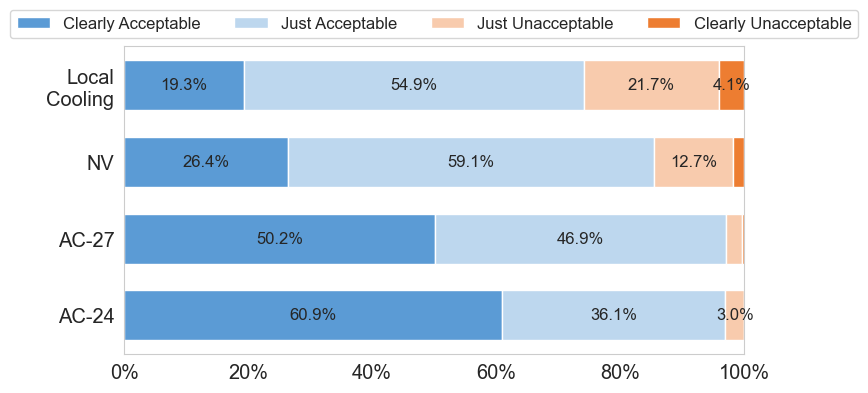

In [10]:
# thermal acceptability
vote = 'TAV'
voteOrder = ['Clearly Acceptable','Just Acceptable','Just Unacceptable','Clearly Unacceptable']
modeOrder = ['Local\nCooling','NV','AC-27','AC-24']
category_colors = c1

voteData = dataPrepare(filtered_data, vote, voteOrder, modeOrder)
category_names = list(voteData.columns)
results = voteData.T.to_dict('list')
survey(results, category_names, category_colors)
plt.show()

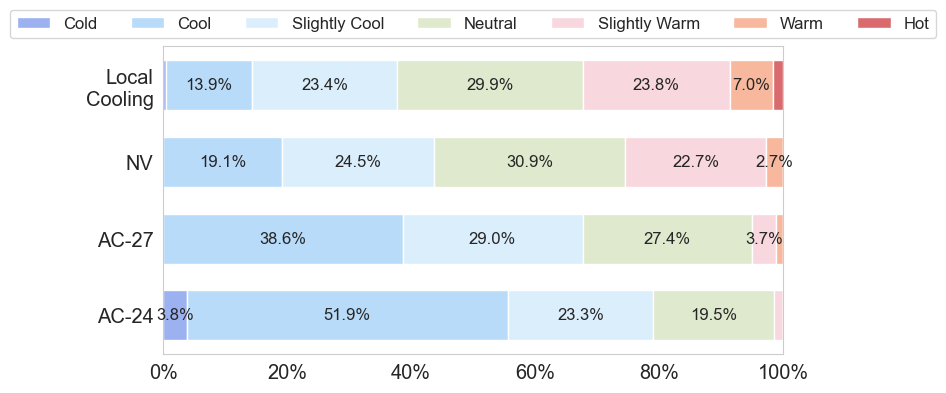

In [11]:
# thermal sensation
vote = 'TSV'
voteOrder = ['Cold','Cool','Slightly Cool','Neutral','Slightly Warm','Warm','Hot']
modeOrder = ['Local\nCooling','NV','AC-27','AC-24']
category_colors = c0

voteData = dataPrepare(filtered_data, vote, voteOrder, modeOrder)
category_names = list(voteData.columns)
results = voteData.T.to_dict('list')
survey(results, category_names, category_colors)
plt.show()

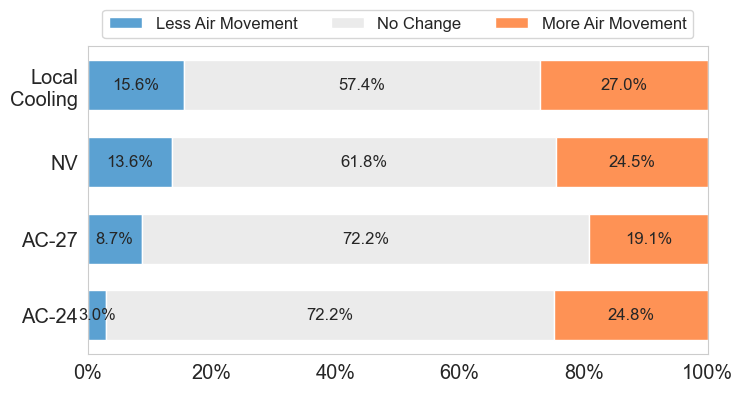

In [12]:
# air movement preference
vote = 'APV'
voteOrder = ['Less Air Movement','No Change','More Air Movement']
modeOrder = ['Local\nCooling','NV','AC-27','AC-24']
category_colors = c2

voteData = dataPrepare(filtered_data, vote, voteOrder, modeOrder)
category_names = list(voteData.columns)
results = voteData.T.to_dict('list')
survey(results, category_names, category_colors)
plt.show()

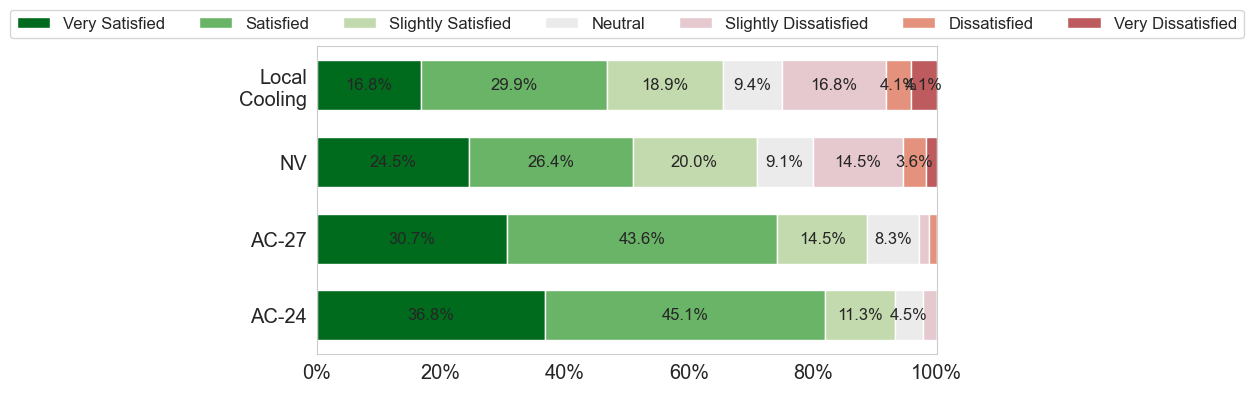

In [13]:
# thermal satisfaction
vote = 'Thermal Satisfaction'
voteOrder = ['Very Satisfied','Satisfied','Slightly Satisfied','Neutral','Slightly Dissatisfied','Dissatisfied','Very Dissatisfied']
modeOrder = ['Local\nCooling','NV','AC-27','AC-24']
category_colors = c3

voteData = dataPrepare(filtered_data, vote, voteOrder, modeOrder)
category_names = list(voteData.columns)
results = voteData.T.to_dict('list')
survey(results, category_names, category_colors)
plt.show()

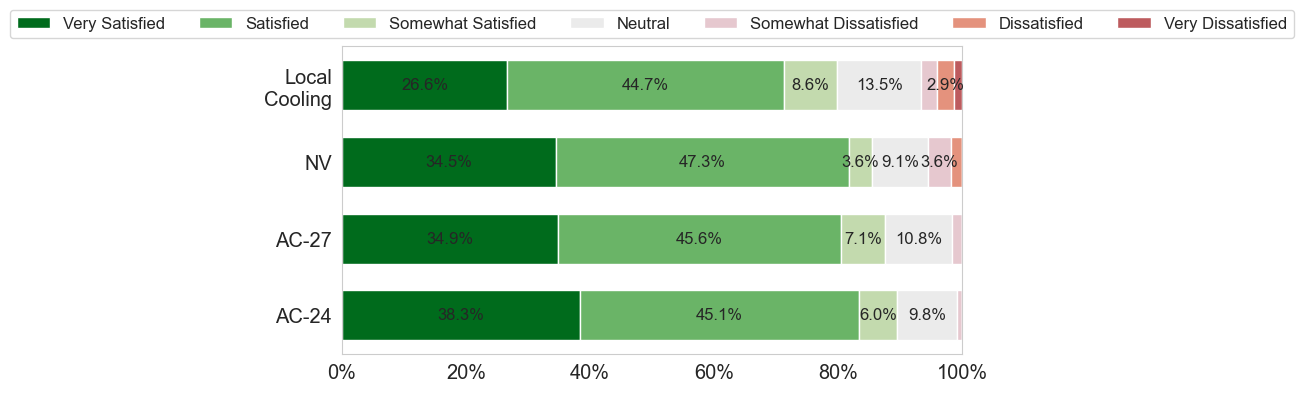

In [14]:
# odor satisfaction
vote = 'Odor Satisfaction'
voteOrder = ['Very Satisfied','Satisfied','Somewhat Satisfied','Neutral','Somewhat Dissatisfied','Dissatisfied','Very Dissatisfied']
modeOrder = ['Local\nCooling','NV','AC-27','AC-24']
category_colors = c3

voteData = dataPrepare(filtered_data, vote, voteOrder, modeOrder)
category_names = list(voteData.columns)
results = voteData.T.to_dict('list')
survey(results, category_names, category_colors)
plt.show()

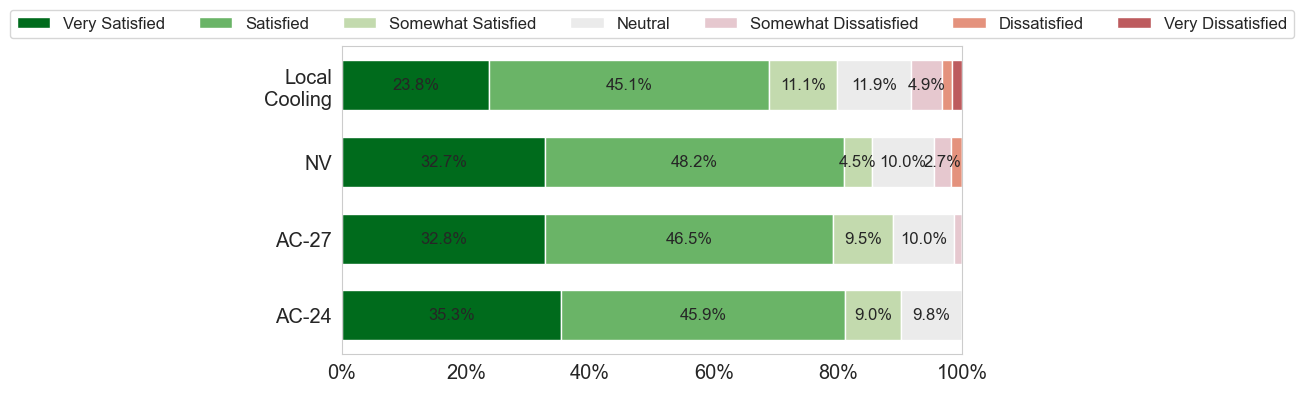

In [15]:
# Overall Indoor Air Quality Satisfaction
vote = 'Air Quality Satisfaction'
voteOrder = ['Very Satisfied','Satisfied','Somewhat Satisfied','Neutral','Somewhat Dissatisfied','Dissatisfied','Very Dissatisfied']
modeOrder = ['Local\nCooling','NV','AC-27','AC-24']
category_colors = c3

voteData = dataPrepare(filtered_data, vote, voteOrder, modeOrder)
category_names = list(voteData.columns)
results = voteData.T.to_dict('list')
survey(results, category_names, category_colors)
plt.show()

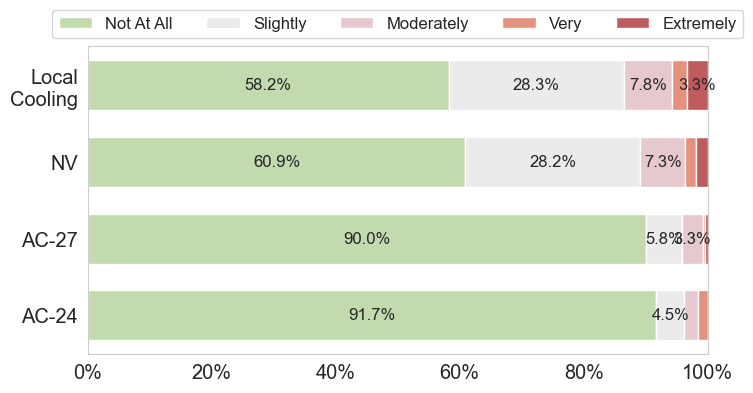

In [16]:
# road traffic noise annoyance
vote = 'Road Traffic Noise Annoyance'
voteOrder = ['Not At All', 'Slightly', 'Moderately', 'Very', 'Extremely']
modeOrder = ['Local\nCooling','NV','AC-27','AC-24']
category_colors = c3[2:]

voteData = dataPrepare(filtered_data, vote, voteOrder, modeOrder)
category_names = list(voteData.columns)
results = voteData.T.to_dict('list')
survey(results, category_names, category_colors)
plt.show()

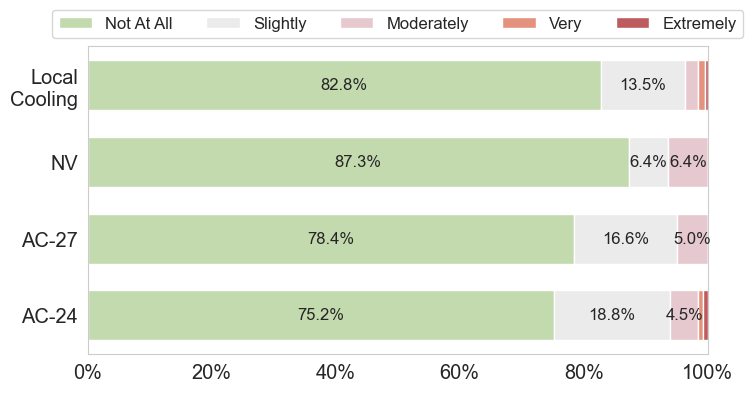

In [17]:
# AC noise annoyance
vote = 'Air-conditioning Noise Annoyance'
voteOrder = ['Not At All', 'Slightly', 'Moderately', 'Very', 'Extremely']
modeOrder = ['Local\nCooling','NV','AC-27','AC-24']
category_colors = c3[2:]

voteData = dataPrepare(filtered_data, vote, voteOrder, modeOrder)
category_names = list(voteData.columns)
results = voteData.T.to_dict('list')
survey(results, category_names, category_colors)
plt.show()

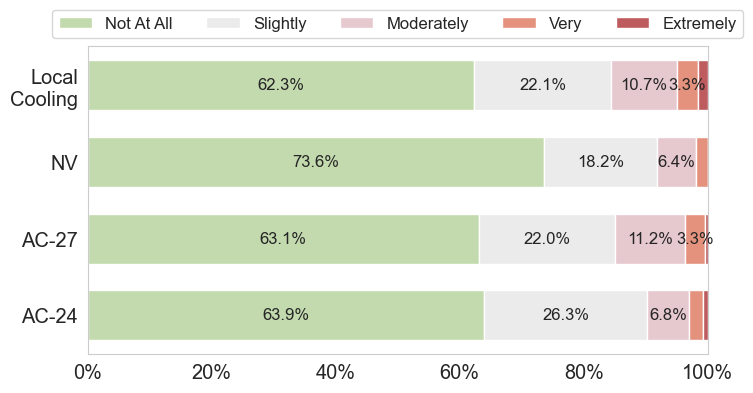

In [18]:
# irrelevant speech noise annoyance
vote = 'Irrelevant Speech Noise Annoyance'
voteOrder = ['Not At All', 'Slightly', 'Moderately', 'Very', 'Extremely']
modeOrder = ['Local\nCooling','NV','AC-27','AC-24']
category_colors = c3[2:]

voteData = dataPrepare(filtered_data, vote, voteOrder, modeOrder)
category_names = list(voteData.columns)
results = voteData.T.to_dict('list')
survey(results, category_names, category_colors)
plt.show()

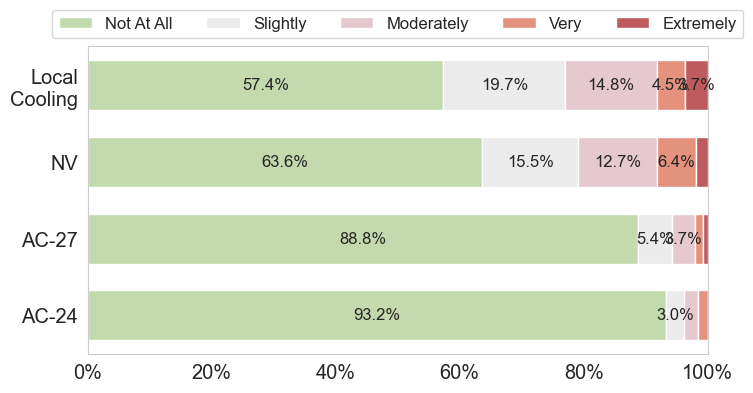

In [19]:
# construction noise annoyance
vote = 'Construction Noise Annoyance'
voteOrder = ['Not At All', 'Slightly', 'Moderately', 'Very', 'Extremely']
modeOrder = ['Local\nCooling','NV','AC-27','AC-24']
category_colors = c3[2:]

voteData = dataPrepare(filtered_data, vote, voteOrder, modeOrder)
category_names = list(voteData.columns)
results = voteData.T.to_dict('list')
survey(results, category_names, category_colors)
plt.show()

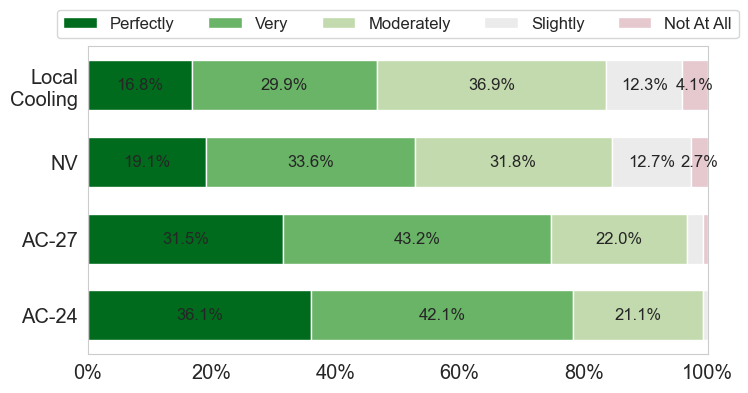

In [20]:
# overall sound environment appropriateness
vote = 'Overall Sound Environment Appropriateness'
voteOrder = ['Perfectly', 'Very', 'Moderately', 'Slightly', 'Not At All']
modeOrder = ['Local\nCooling','NV','AC-27','AC-24']
category_colors = c3

voteData = dataPrepare(filtered_data, vote, voteOrder, modeOrder)
category_names = list(voteData.columns)
results = voteData.T.to_dict('list')
survey(results, category_names, category_colors)
plt.show()

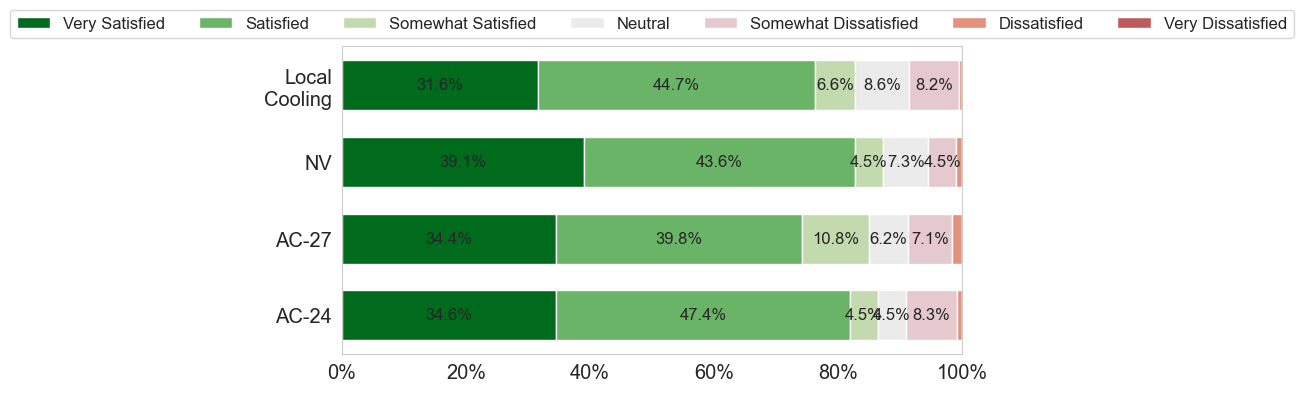

In [21]:
# ceiling light satisfaction
vote = 'Ceiling Light Satisfaction'
voteOrder = ['Very Satisfied','Satisfied','Somewhat Satisfied','Neutral','Somewhat Dissatisfied','Dissatisfied','Very Dissatisfied']
modeOrder = ['Local\nCooling','NV','AC-27','AC-24']
category_colors = c3

voteData = dataPrepare(filtered_data, vote, voteOrder, modeOrder)
category_names = list(voteData.columns)
results = voteData.T.to_dict('list')
survey(results, category_names, category_colors)
plt.show()

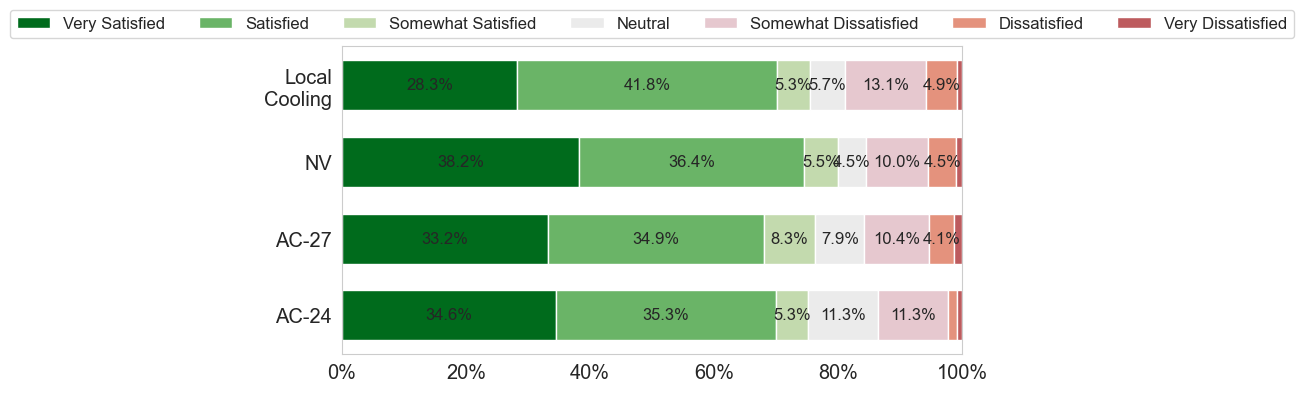

In [22]:
# natrual light satisfaction
vote = 'Natural Light Satisfaction'
voteOrder = ['Very Satisfied','Satisfied','Somewhat Satisfied','Neutral','Somewhat Dissatisfied','Dissatisfied','Very Dissatisfied']
modeOrder = ['Local\nCooling','NV','AC-27','AC-24']
category_colors = c3

voteData = dataPrepare(filtered_data, vote, voteOrder, modeOrder)
category_names = list(voteData.columns)
results = voteData.T.to_dict('list')
survey(results, category_names, category_colors)
plt.show()

## Thermal comfort responses over the weeks
aggregate the occupant responses by week to visualize changes over time

In [23]:
# Function to drop Week == 15 and calculate percentage of each comfort index category by Week and Mode
def calculate_percentage(df, comfort_index, vote_order):
    # Drop rows where Week == 15
    df = df[df['Week'] != 15]
    
    # Group by Week, Mode, and the comfort index (TSV or TAV)
    percentage_df = df.groupby(['Week', 'Mode', comfort_index]).size().reset_index(name='count')
    
    # Calculate the total count per Week and Mode
    total_per_week = percentage_df.groupby(['Week', 'Mode'])['count'].transform('sum')
    
    # Calculate the percentage of each category
    percentage_df['percentage'] = (percentage_df['count'] / total_per_week) * 100
    
    # Ensure the order of categories follows voteOrder
    percentage_df[comfort_index] = pd.Categorical(percentage_df[comfort_index], categories=vote_order, ordered=True)
    
    return percentage_df

# Function to format Y-axis as percentages
def percentage_formatter(x, pos):
    return f'{x:.0f}%'

In [24]:
# Function to plot stacked bar chart with customization and add percentage labels
def plot_stacked_bar(percentage_df, comfort_index, vote_order, color_palette):
    # Set up the plot
    plt.figure(figsize=(12, 5))
    
    # Loop through each Mode to create a stacked bar chart for each mode
    modes = percentage_df['Mode'].unique()
    
    for mode in modes:
        mode_data = percentage_df[percentage_df['Mode'] == mode]
        
        # Pivot the data to get categories in columns and percentages as values
        pivot_data = mode_data.pivot_table(values='percentage', index='Week', columns=comfort_index, fill_value=0)
        
        # Ensure all categories are present in the plot even if some are missing in the data
        pivot_data = pivot_data.reindex(columns=vote_order, fill_value=0)

        # Plot the stacked bar chart with the specified color palette and slightly smaller bar width
        ax = pivot_data.plot(kind='bar', stacked=True, width=0.8, 
                             color=sns.color_palette(color_palette, n_colors=len(pivot_data.columns)), figsize=(12, 6))
        
        # Add percentage labels to each segment
        for i, (week, row) in enumerate(pivot_data.iterrows()):
            cumulative = 0
            for category in vote_order:
                percentage = row[category]
                if percentage >= 5:  # Show label only if the percentage is 5% or more
                    ax.text(i, cumulative + percentage / 2, f'{int(round(percentage))}', 
                            ha='center', va='center', fontsize=22, color='#555555')
                cumulative += percentage

        # Customize the axis labels and ticks
        plt.xlabel('Week in MMV installation', fontsize=24)
        plt.ylabel('Percentage', fontsize=24)
        ax.set_title(mode, fontsize=24)

        # Customize the legend
        #ax.legend(ncol=len(pivot_data.columns), bbox_to_anchor=(0.5, 1), loc='lower center', fontsize='x-large')

        # Format Y-axis with percentage sign
        ax.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
        ax.set(ylim=(0, 103))
        
        # Set tick parameters
        plt.xticks(rotation=0, fontsize=24)
        plt.yticks(fontsize=24)

        # Remove grid lines
        ax.grid(False)
        ax.legend_.remove()

        plt.tight_layout()
        #plt.savefig('../results/figures/' + comfort_index + '_' + mode + '.png', dpi=300, transparent=True, bbox_inches='tight')
        plt.show()

<Figure size 1200x500 with 0 Axes>

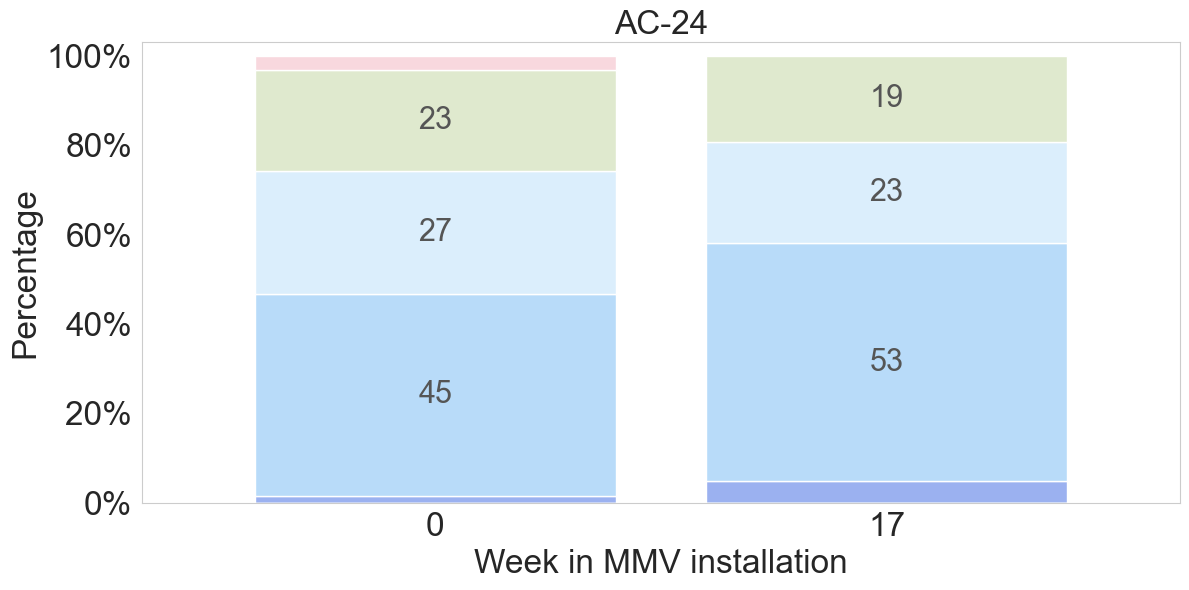

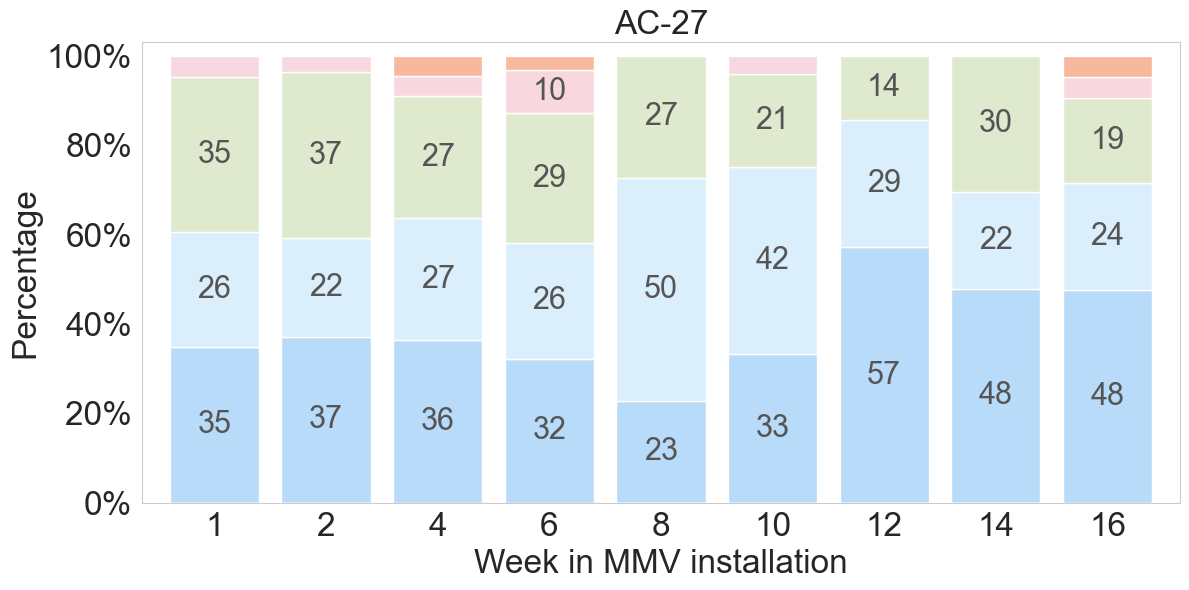

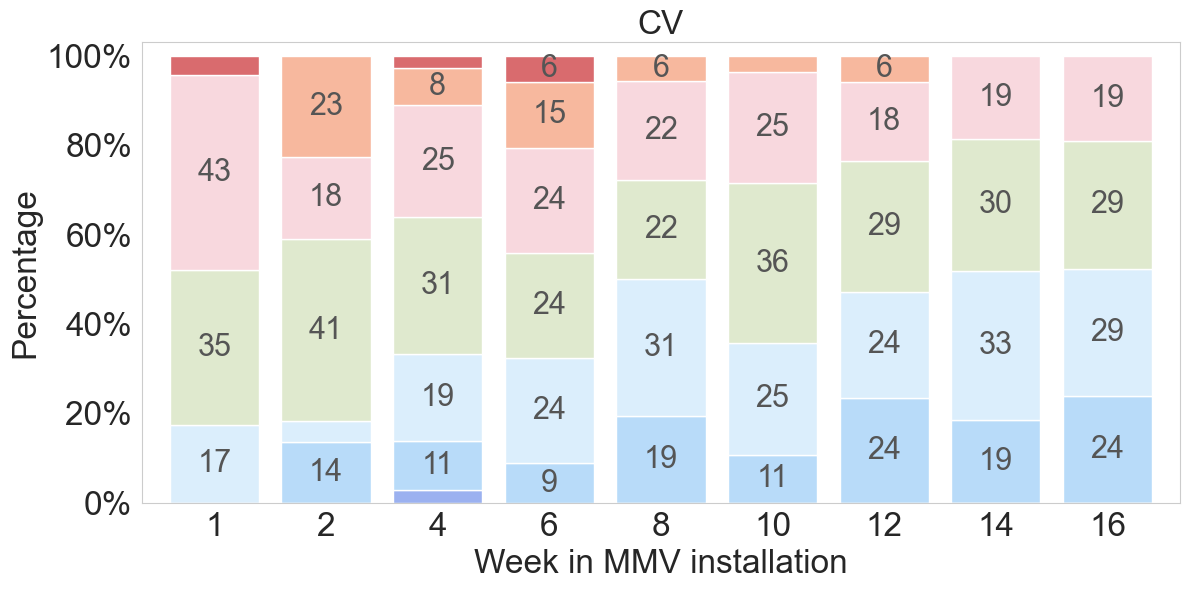

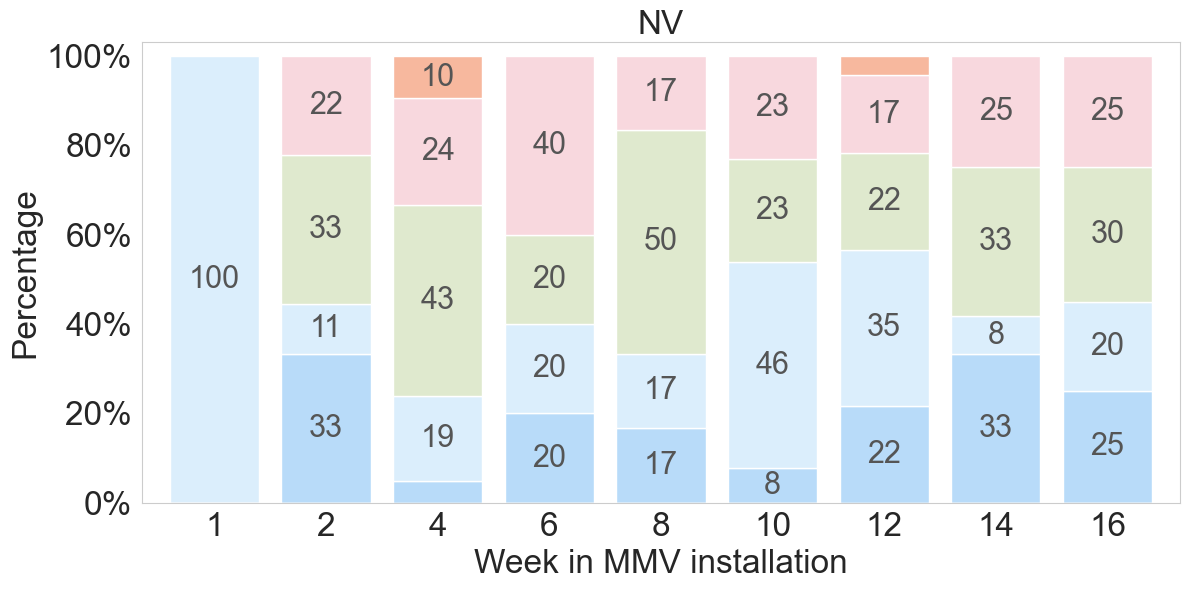

In [25]:
# thermal sensation by week for AC, localized cooling, and NV mode, respectively
tsv_vote_order = ['Cold', 'Cool', 'Slightly Cool', 'Neutral', 'Slightly Warm', 'Warm', 'Hot']
tsv_percentage = calculate_percentage(filteredCompleteData, 'TSV', tsv_vote_order)
plot_stacked_bar(tsv_percentage, 'TSV', tsv_vote_order, c0)

<Figure size 1200x500 with 0 Axes>

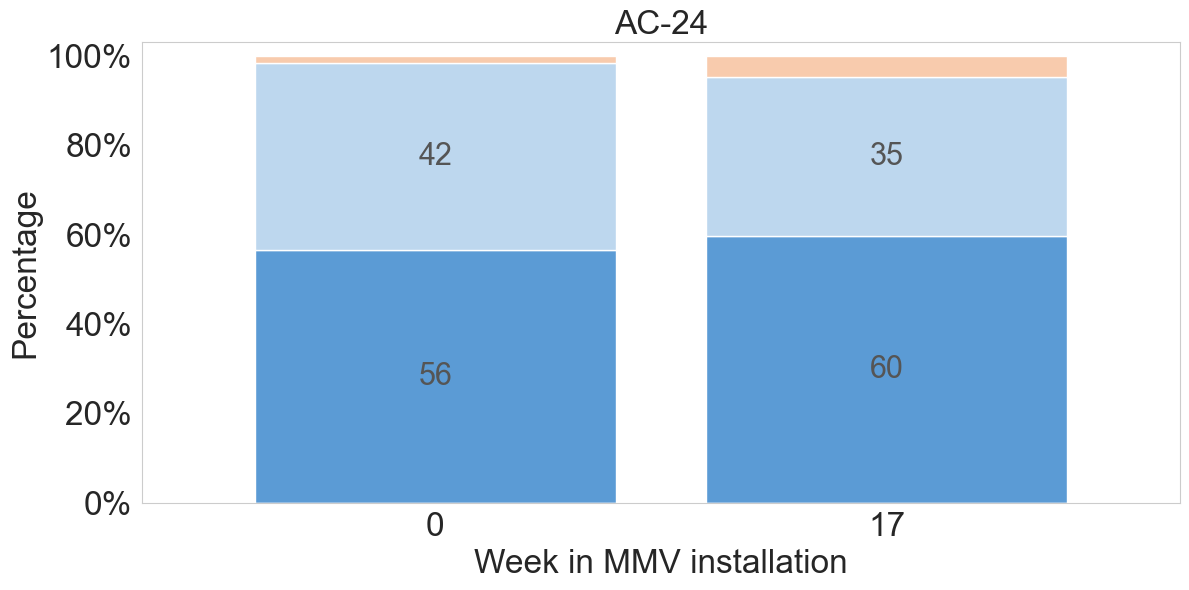

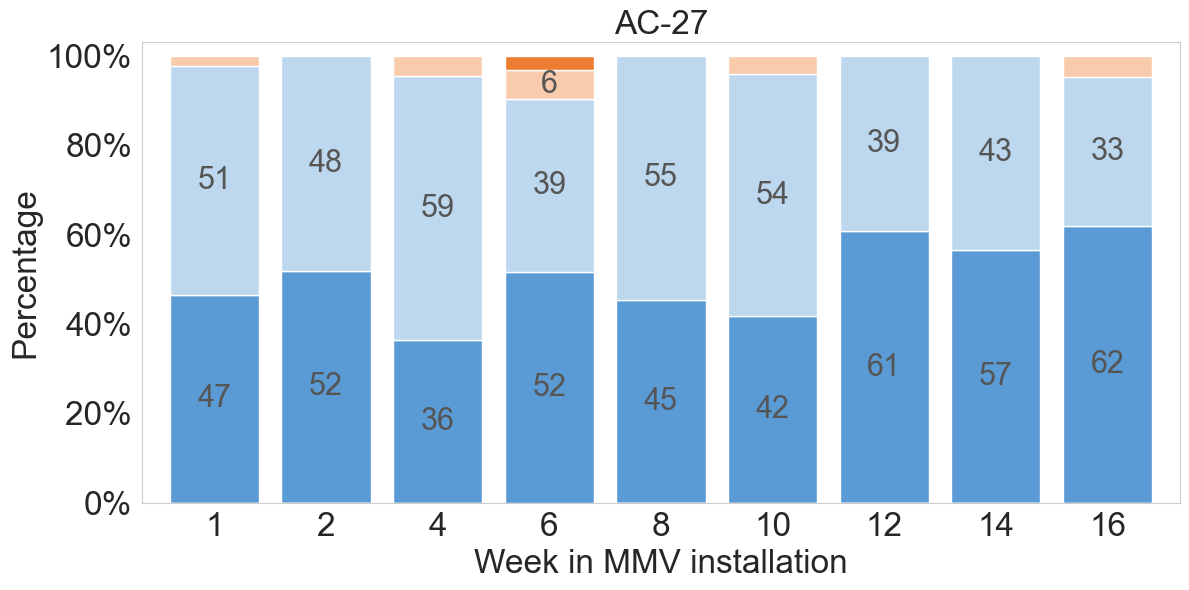

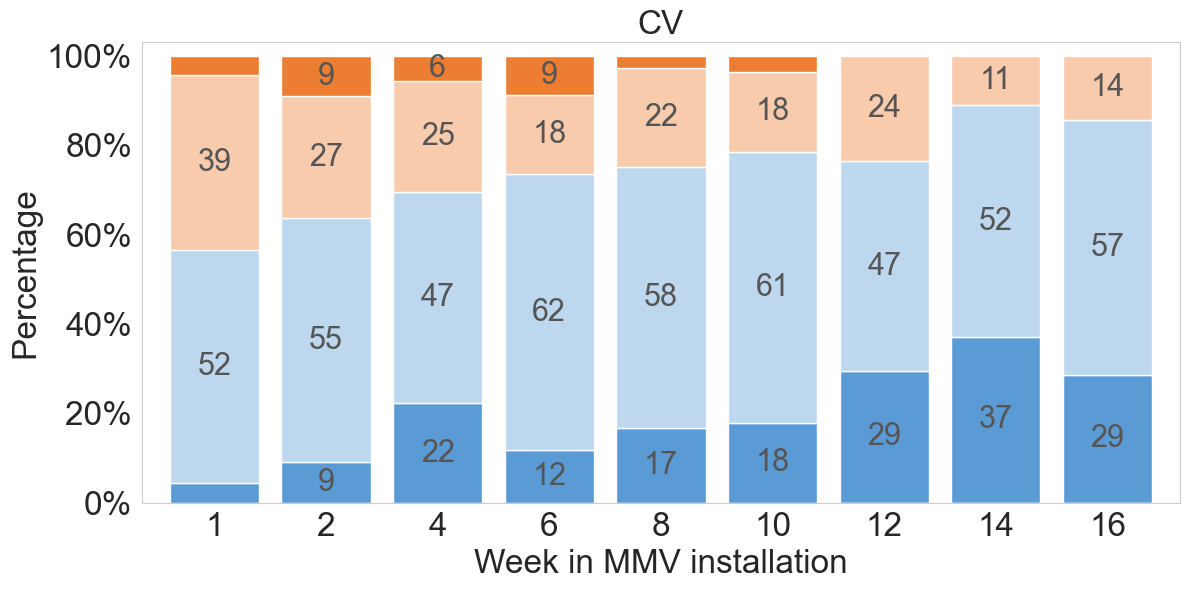

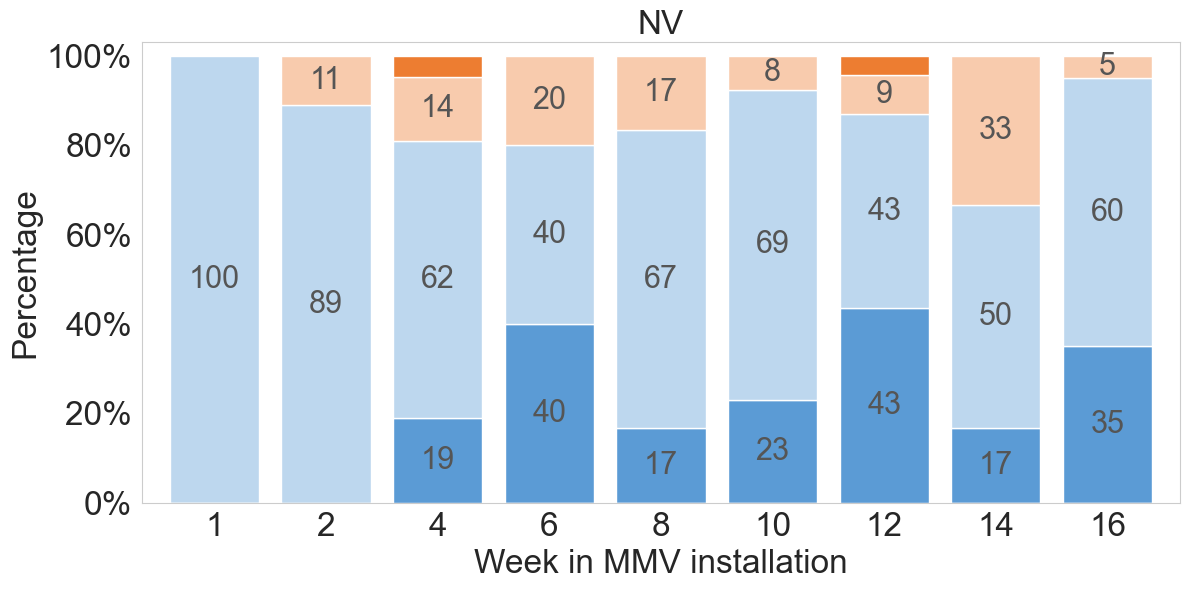

In [26]:
# thermal acceptability by week for AC, localized cooling, and NV mode, respectively
tav_vote_order = ['Clearly Acceptable', 'Just Acceptable', 'Just Unacceptable', 'Clearly Unacceptable']
tav_percentage = calculate_percentage(filteredCompleteData, 'TAV', tav_vote_order)
plot_stacked_bar(tav_percentage, 'TAV', tav_vote_order, c1)

<Figure size 1200x500 with 0 Axes>

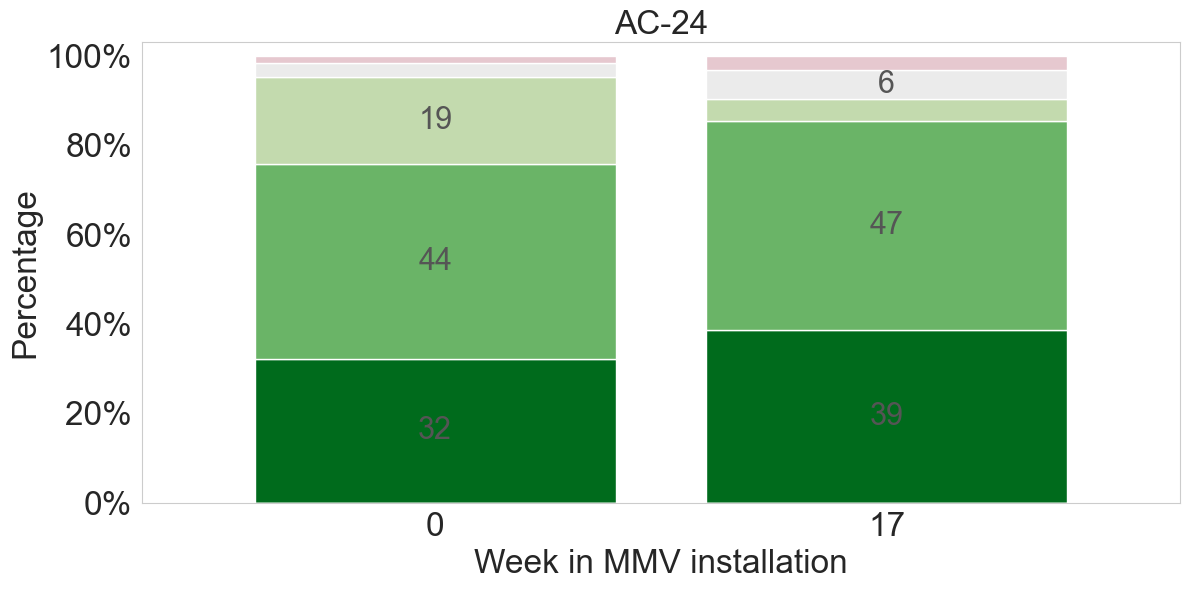

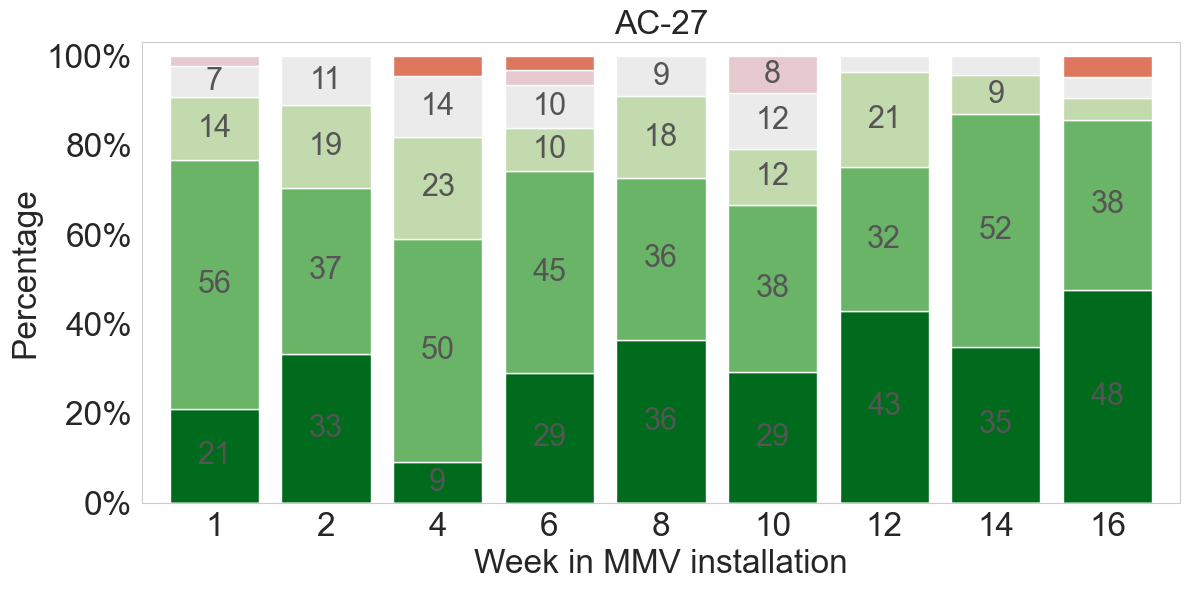

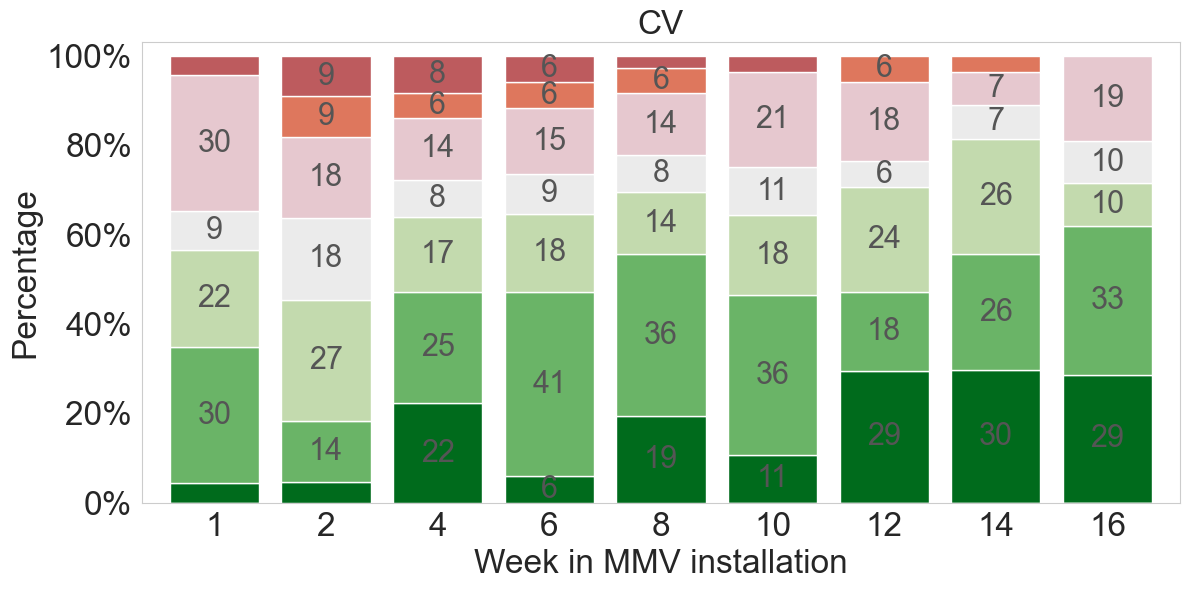

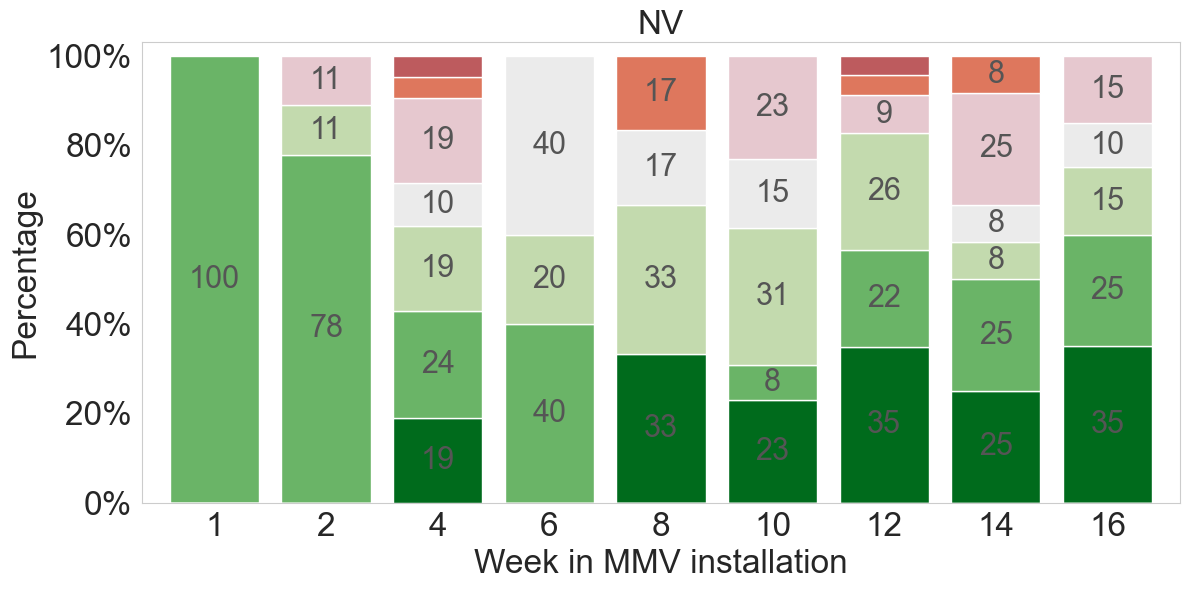

In [27]:
# thermal satisfaction by week for AC, localized cooling, and NV mode, respectively
satisfaction_vote_order = ['Very Satisfied','Satisfied','Slightly Satisfied','Neutral','Slightly Dissatisfied','Dissatisfied','Very Dissatisfied']
satisfaction_vote_percentage = calculate_percentage(filteredCompleteData, 'Thermal Satisfaction', satisfaction_vote_order)

# Plot Thermal satisfaction using the 'c3' color palette
plot_stacked_bar(satisfaction_vote_percentage, 'Thermal Satisfaction', satisfaction_vote_order, c3)

## statistical testing for changes in clothing insulation
hypothesis 1: there is no difference in clothing insulation by mode\
hypothesis 2: there is no difference in clothing insulation by week

In [28]:
# Import necessary libraries
import pandas as pd
import statsmodels.formula.api as smf
from scipy import stats
import numpy as np
import warnings
import statsmodels.api as sm

# Ignore warnings for now
warnings.filterwarnings("ignore")

# Assuming 'filteredCompleteData' is your DataFrame
data = filteredCompleteData.dropna(subset=['Clo', 'Mode', 'Week', 'ID']).copy()
data['Mode'] = data['Mode'].astype('category')
data['Week'] = data['Week'].astype('int')
data['ID'] = data['ID'].astype('category')

# Simplify Week variable
def week_group(week):
    if week <= 5:
        return 'Early'
    elif week <= 10:
        return 'Mid'
    else:
        return 'Late'

data['WeekGroup'] = data['Week'].apply(week_group).astype('category')

# Fit the simplified LME model
model_full = smf.mixedlm('Clo ~ Mode + WeekGroup', data, groups=data['ID'])
result_full = model_full.fit(reml=False)

model_no_mode = smf.mixedlm('Clo ~ WeekGroup', data, groups=data['ID'])
result_no_mode = model_no_mode.fit(reml=False)

model_no_week = smf.mixedlm('Clo ~ Mode', data, groups=data['ID'])
result_no_week = model_no_week.fit(reml=False)

# Perform Likelihood Ratio Test for Mode
lr_stat_mode = 2 * (result_full.llf - result_no_mode.llf)
df_mode = result_full.df_modelwc - result_no_mode.df_modelwc
p_value_mode = stats.chi2.sf(lr_stat_mode, df_mode)
print(f"P-value for Mode: {p_value_mode:.3f}")

# Perform Likelihood Ratio Test for WeekGroup
lr_stat_week = 2 * (result_full.llf - result_no_week.llf)
df_week = result_full.df_modelwc - result_no_week.df_modelwc
p_value_week = stats.chi2.sf(lr_stat_week, df_week)
print(f"P-value for WeekGroup: {p_value_week:.3f}")

# If issues persist, try GEE
gee_model = sm.GEE.from_formula('Clo ~ Mode + Week', groups='ID', data=data)
gee_result = gee_model.fit()
print(gee_result.summary())

# Extract overall P-values using the largest P-value among levels
p_value_mode_gee = gee_result.pvalues[[col for col in gee_result.params.index if 'Mode' in col]].max()
p_value_week_gee = gee_result.pvalues[[col for col in gee_result.params.index if 'Week' in col]].max()

print(f"P-value for Mode (GEE): {p_value_mode_gee:.3f}")
print(f"P-value for Week (GEE): {p_value_week_gee:.3f}")


P-value for Mode: 0.004
P-value for WeekGroup: 0.000
                               GEE Regression Results                              
Dep. Variable:                         Clo   No. Observations:                  728
Model:                                 GEE   No. clusters:                       34
Method:                        Generalized   Min. cluster size:                   4
                      Estimating Equations   Max. cluster size:                  30
Family:                           Gaussian   Mean cluster size:                21.4
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Mon, 28 Apr 2025   Scale:                           0.006
Covariance type:                    robust   Time:                         16:23:12
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.4021   

## comparison of in-situ thermal environmental measurements during survey completion by week 

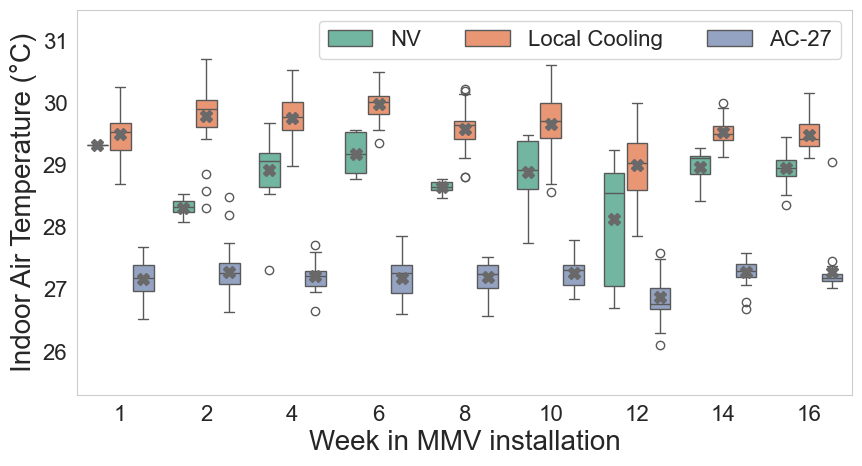

In [29]:
mode_name_mapping = {'CV': 'Local Cooling', 'AC-24': 'AC-24', 'AC-27': 'AC-27', 'NV': 'NV'}

plt.figure(figsize=(10, 5))
ax = sns.boxplot(
    data=filteredCompleteData[filteredCompleteData["Mode"] != 'AC-24'].replace({'Mode': mode_name_mapping}),
    x="Week",
    y="Temperature",
    hue="Mode",
    hue_order=["NV", "Local Cooling", "AC-27"],
    gap=0.1,
    palette=sns.color_palette("Set2"),
    showmeans=True,
    meanprops={"marker":"X", "markerfacecolor":"dimgrey", "markeredgecolor":"dimgrey","markersize":8}
)
ax.set(ylim=(25.3, 31.5))

sns.move_legend(ax, "upper left")
ax.set_yticks(np.arange(26, 32, 1))
ax.set_ylabel('Indoor Air Temperature (°C)', fontsize=20)
ax.set_xlabel('Week in MMV installation', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc='upper right', fontsize=16, ncol=3)
ax.grid(False)

#plt.savefig('../results/figures/Weekly comparison_box_temp.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()


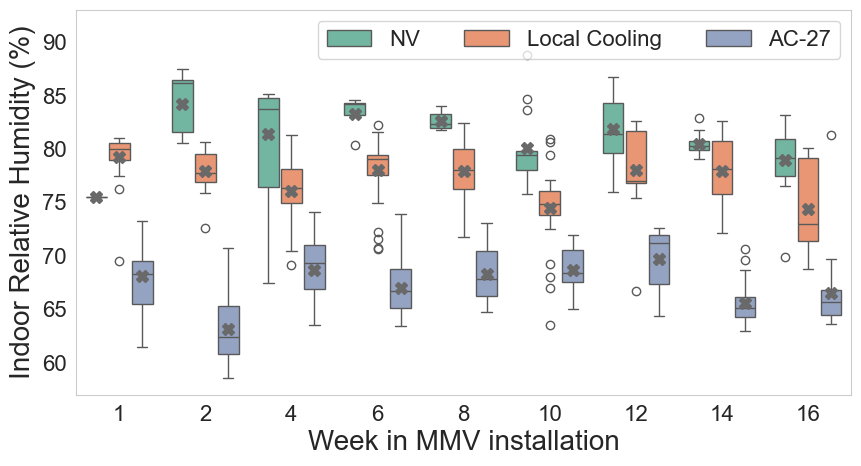

In [30]:
mode_name_mapping = {'CV': 'Local Cooling', 'AC-24': 'AC-24', 'AC-27': 'AC-27', 'NV': 'NV'}

plt.figure(figsize=(10, 5))
ax = sns.boxplot(
    data=filteredCompleteData[filteredCompleteData["Mode"] != 'AC-24'].replace({'Mode': mode_name_mapping}),
    x="Week",
    y="RH",
    hue="Mode",
    hue_order=["NV", "Local Cooling", "AC-27"],
    gap=0.1,
    palette=sns.color_palette("Set2"),
    showmeans=True,
    meanprops={"marker":"X", "markerfacecolor":"dimgrey", "markeredgecolor":"dimgrey","markersize":8}
)
ax.set(ylim=(57, 93))

sns.move_legend(ax, "upper left")
#ax.set_yticks(np.arange(60, 90, 5))
ax.set_ylabel('Indoor Relative Humidity (%)', fontsize=20)
ax.set_xlabel('Week in MMV installation', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc='upper right', fontsize=16, ncol=3)
ax.grid(False)

#plt.savefig('../results/figures/Weekly comparison_box_rh.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()


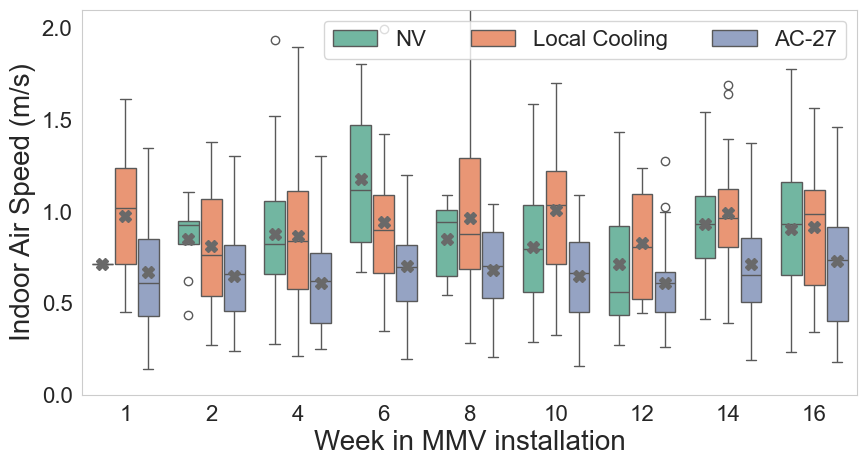

In [31]:
mode_name_mapping = {'CV': 'Local Cooling', 'AC-24': 'AC-24', 'AC-27': 'AC-27', 'NV': 'NV'}

plt.figure(figsize=(10, 5))
ax = sns.boxplot(
    data=filteredCompleteData[filteredCompleteData["Mode"] != 'AC-24'].replace({'Mode': mode_name_mapping}),
    x="Week",
    y="Air Speed",
    hue="Mode",
    hue_order=["NV", "Local Cooling", "AC-27"],
    gap=0.1,
    palette=sns.color_palette("Set2"),
    showmeans=True,
    meanprops={"marker":"X", "markerfacecolor":"dimgrey", "markeredgecolor":"dimgrey","markersize":8}
)
ax.set(ylim=(0, 2.1))

sns.move_legend(ax, "upper left")
#ax.set_yticks(np.arange(60, 90, 5))
ax.set_ylabel('Indoor Air Speed (m/s)', fontsize=20)
ax.set_xlabel('Week in MMV installation', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc='upper right', fontsize=16, ncol=3)
ax.grid(False)

#plt.savefig('../results/figures/Weekly comparison_box_airspeed.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()


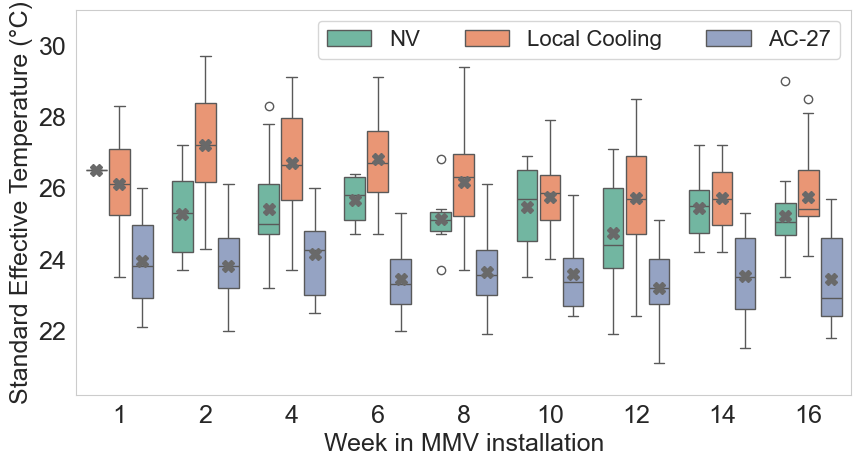

In [32]:
mode_name_mapping = {'CV': 'Local Cooling', 'AC-24': 'AC-24', 'AC-27': 'AC-27', 'NV': 'NV'}

plt.figure(figsize=(10, 5))
ax = sns.boxplot(
    data=filteredCompleteData[filteredCompleteData["Mode"] != 'AC-24'].replace({'Mode': mode_name_mapping}),
    x="Week",
    y="SET",
    hue="Mode",
    hue_order=["NV", "Local Cooling", "AC-27"],
    gap=0.1,
    palette=sns.color_palette("Set2"),
    showmeans=True,
    meanprops={"marker":"X", "markerfacecolor":"dimgrey", "markeredgecolor":"dimgrey","markersize":8}
)
ax.set(ylim=(20.2, 31))

sns.move_legend(ax, "upper left")
ax.set_yticks(np.arange(22, 31, 2))
ax.set_ylabel('Standard Effective Temperature (°C)', fontsize=18)
ax.set_xlabel('Week in MMV installation', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc='upper right', fontsize=16, ncol=3)
ax.grid(False)

#plt.savefig('../results/figures/Weekly comparison_box_set.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()


## comparison of in-situ IEQ measurements during survey completion by week (table format)

In [33]:
# Thermal measurement
from pathlib import Path

df = filteredCompleteData.copy()
mode_order     = ["NV", "CV", "AC-27"]
variable_order = ["Temperature", "RH", "Air Speed", "Clo", "SET", "MRT"]
week_order     = [1, 2, 4, 6, 8, 10, 12, 14, 16]

# decimal map (default 1)
decimals = {"Air Speed": 2, "Clo": 2}

def fmt(series):
    """
    Format as mean$\\pm$sd (no spaces) with 1 decimal place everywhere.
    If only one sample (sd undefined), just show the mean.
    """
    mean = series.mean()
    sd   = series.std(ddof=1)           # sample SD needs ≥2 samples
    if series.count() < 2 or pd.isna(sd):
        return f"{mean:.1f}"
    return f"{mean:.1f}$\\pm${sd:.1f}"

records = []
for mode in mode_order:
    mode_df = df[df["Mode"] == mode]
    if mode_df.empty:
        continue
    for var in variable_order:
        rec = {"Mode": mode, "Variable": var}
        # Week columns
        for wk in week_order:
            subset = mode_df.loc[mode_df["Week"] == wk, var]
            rec[wk] = fmt(subset) if not subset.empty else ""
        # Overall mean ± SD across all weeks
        rec["Mean"] = fmt(mode_df[var])
        records.append(rec)

cols  = ["Mode", "Variable"] + week_order + ["Mean"]
final = pd.DataFrame(records)[cols]

latex_path = Path("mode_week_thermalsummary_with_sd.tex")
#final.to_latex(latex_path, index=False, escape=False, column_format="ll" + "r" * (len(week_order) + 1))
final

,Mode,Variable,1,2,4,6,8,10,12,14,16,Mean
0,NV,Temperature,29.3,28.3$\pm$0.1,28.9$\pm$0.5,29.2$\pm$0.4,28.6$\pm$0.1,28.9$\pm$0.6,28.1$\pm$0.9,29.0$\pm$0.3,28.9$\pm$0.3,28.7$\pm$0.6
1,NV,RH,75.5,84.2$\pm$2.9,81.4$\pm$4.9,83.3$\pm$1.7,82.6$\pm$0.9,80.1$\pm$3.6,81.8$\pm$2.9,80.4$\pm$1.1,78.9$\pm$2.9,81.1$\pm$3.5
2,NV,Air Speed,0.7,0.8$\pm$0.2,0.9$\pm$0.4,1.2$\pm$0.5,0.9$\pm$0.2,0.8$\pm$0.4,0.7$\pm$0.3,0.9$\pm$0.3,0.9$\pm$0.4,0.9$\pm$0.4
3,NV,Clo,0.4,0.4$\pm$0.1,0.3$\pm$0.1,0.4$\pm$0.1,0.4$\pm$0.1,0.3$\pm$0.1,0.3$\pm$0.1,0.4$\pm$0.1,0.3$\pm$0.1,0.3$\pm$0.1
4,NV,SET,26.5,25.3$\pm$1.3,25.4$\pm$1.4,25.7$\pm$0.7,25.1$\pm$1.0,25.5$\pm$1.1,24.7$\pm$1.4,25.4$\pm$0.9,25.2$\pm$1.2,25.2$\pm$1.2
5,NV,MRT,29.9,29.1$\pm$0.3,29.1$\pm$0.6,29.4$\pm$0.4,28.8$\pm$0.4,28.9$\pm$0.6,28.4$\pm$0.8,29.3$\pm$0.6,29.1$\pm$0.4,29.0$\pm$0.6
6,CV,Temperature,29.5$\pm$0.4,29.8$\pm$0.6,29.8$\pm$0.4,30.0$\pm$0.3,29.6$\pm$0.3,29.7$\pm$0.5,29.0$\pm$0.6,29.5$\pm$0.2,29.5$\pm$0.3,29.6$\pm$0.4
7,CV,RH,79.2$\pm$2.4,77.9$\pm$1.9,76.0$\pm$3.0,78.0$\pm$2.9,78.0$\pm$2.8,74.4$\pm$3.8,78.0$\pm$3.9,77.9$\pm$3.0,74.4$\pm$3.9,77.1$\pm$3.4
8,CV,Air Speed,1.0$\pm$0.3,0.8$\pm$0.3,0.9$\pm$0.4,0.9$\pm$0.4,1.0$\pm$0.4,1.0$\pm$0.4,0.8$\pm$0.3,1.0$\pm$0.3,0.9$\pm$0.3,0.9$\pm$0.4
9,CV,Clo,0.4$\pm$0.1,0.4$\pm$0.1,0.4$\pm$0.1,0.4$\pm$0.1,0.4$\pm$0.1,0.4$\pm$0.1,0.4$\pm$0.1,0.3$\pm$0.1,0.4$\pm$0.1,0.4$\pm$0.1


In [34]:
# PM and TVOC is only available in our continous monitoring
continousMonitoring = pd.read_csv('../data/comfort/backgroundContinousMonitoring.csv', index_col=0, parse_dates=True)

iaq_clean = continousMonitoring.copy()
iaq_clean.loc[iaq_clean["tvoc"] > 1000, "tvoc"] = pd.NA   # or np.nan (correct for sensor error)
# Resample to a strict 1‑minute grid and interpolate gaps
cols = ["pm2.5", "tvoc"]

iaq_minutely = (iaq_clean[cols].resample("1min").mean().interpolate(method="time", limit_direction="both"))

# Bring nearest values (within ±30 s) into df
tolerance = pd.Timedelta("30s")

mapping = {"pm2.5": "PM2.5", "tvoc": "TVOC"}

for raw_col, new_col in mapping.items():
    df[new_col] = (
        iaq_minutely[raw_col]
          .reindex(df.index, method="nearest", tolerance=tolerance)
          .values
    )

In [35]:
# Acoustic, IAQ, and lighting measurement
mode_order     = ["NV", "CV", "AC-27"]
variable_order = [
    "CO2", "PM2.5", "TVOC", "Noise measurement (LAeq)", "Lighting measurement (Lux)"]
week_order     = [1, 2, 4, 6, 8, 10, 12, 14, 16]

dp = {"CO2": 0, "TVOC": 0, "Lighting measurement (Lux)": 0} # default will be 1 dp

def fmt(series, var):
    """
    Return mean$\\pm$sd with variable‑specific decimals.
    If only one sample (sd undefined) → just mean.
    """
    mean = series.mean()
    sd   = series.std(ddof=1)
    decimals = dp.get(var, 1)          # 0 for int‑rounded vars, else 1
    base_fmt = f"{{:.{decimals}f}}"
    if series.count() < 2 or pd.isna(sd):
        return base_fmt.format(mean)
    return base_fmt.format(mean) + "$\\pm$" + base_fmt.format(sd)

records = []
for mode in mode_order:
    mode_df = df[df["Mode"] == mode]
    if mode_df.empty:
        continue
    for var in variable_order:
        rec = {"Mode": mode, "Variable": var}
        for wk in week_order:
            subset = mode_df.loc[mode_df["Week"] == wk, var]
            rec[wk] = fmt(subset, var) if not subset.empty else ""
        rec["Mean"] = fmt(mode_df[var], var)
        records.append(rec)

cols  = ["Mode", "Variable"] + week_order + ["Mean"]
final = pd.DataFrame(records)[cols]

latex_path = Path("mode_week_IAQsummary_with_sd.tex")
#final.to_latex(latex_path, index=False, escape=False, column_format="ll" + "r" * (len(week_order) + 1))
final

,Mode,Variable,1,2,4,6,8,10,12,14,16,Mean
0,NV,CO2,458,438$\pm$16,460$\pm$38,432$\pm$22,442$\pm$16,439$\pm$21,429$\pm$16,422$\pm$20,426$\pm$19,437$\pm$26
1,NV,PM2.5,11.3,4.8$\pm$0.3,10.2$\pm$2.7,10.1$\pm$5.2,10.4$\pm$6.3,8.6$\pm$3.2,8.0$\pm$4.5,18.8$\pm$7.7,8.9$\pm$2.5,9.8$\pm$5.3
2,NV,TVOC,169,67$\pm$6,146$\pm$54,229$\pm$68,327$\pm$124,207$\pm$135,133$\pm$103,297$\pm$60,197$\pm$100,184$\pm$111
3,NV,Noise measurement (LAeq),48.6,48.6$\pm$1.2,50.3$\pm$2.5,50.5$\pm$0.8,49.0$\pm$1.8,51.2$\pm$3.0,50.2$\pm$1.9,50.2$\pm$2.1,50.4$\pm$2.6,50.2$\pm$2.3
4,NV,Lighting measurement (Lux),423,300$\pm$117,293$\pm$116,319$\pm$98,300$\pm$125,322$\pm$111,330$\pm$115,324$\pm$114,300$\pm$114,312$\pm$112
5,CV,CO2,438$\pm$19,427$\pm$14,435$\pm$17,424$\pm$15,433$\pm$15,430$\pm$16,424$\pm$15,423$\pm$16,423$\pm$15,429$\pm$17
6,CV,PM2.5,10.2$\pm$2.7,4.2$\pm$1.2,7.7$\pm$2.6,6.2$\pm$4.1,7.1$\pm$3.8,6.2$\pm$1.9,8.9$\pm$4.4,20.1$\pm$7.8,10.7$\pm$6.4,8.8$\pm$6.0
7,CV,TVOC,62$\pm$28,50$\pm$26,107$\pm$42,89$\pm$56,176$\pm$98,141$\pm$83,159$\pm$98,285$\pm$149,229$\pm$182,143$\pm$117
8,CV,Noise measurement (LAeq),50.1$\pm$1.8,50.8$\pm$2.1,50.8$\pm$2.3,50.7$\pm$1.9,50.6$\pm$1.9,50.9$\pm$2.2,50.9$\pm$1.7,50.3$\pm$1.8,50.1$\pm$1.3,50.6$\pm$1.9
9,CV,Lighting measurement (Lux),306$\pm$107,345$\pm$127,335$\pm$114,336$\pm$123,318$\pm$119,331$\pm$120,344$\pm$123,326$\pm$105,341$\pm$130,330$\pm$117


## comparison of indoor measurements during the whole period of each mode
instead of looking at the thermal conditions during the survey, we also examine the whole period of each mode

In [36]:
# calculate statistical summary of temperature grouped by mode

# the mode info can be inferred from the energy data
energyData = pd.read_csv('../data/energy/energy_meter.csv')
energyData['Timestamp'] = pd.to_datetime(energyData['Timestamp']).dt.tz_localize(None)
energyData.set_index('Timestamp', inplace=True)

# Resample to 5-minute intervals and forward-fill mode column
energyData = energyData.resample('5T').ffill()
continousMonitoring = continousMonitoring.join(energyData[['mode','P53 OutdoorTempAve']], how='left')
statistical_summary = continousMonitoring.groupby('mode')['temperature'].describe()
print(statistical_summary)

         count       mean       std        min        25%        50%  \
mode                                                                   
AC-24   6048.0  26.765787  1.683621  23.492065  24.765145  27.254403   
AC-27  16015.0  28.231593  1.008718  25.857977  27.165274  28.535516   
CV     10458.0  28.851999  0.586512  26.481765  28.570497  28.835661   
NV      6498.0  28.403927  0.579319  25.942893  28.096113  28.514019   

             75%        max  
mode                         
AC-24  28.158849  30.034104  
AC-27  28.982581  30.468567  
CV     29.163727  30.599768  
NV     28.778766  29.915274  


In [37]:
# indoor temperature by mode
statistical_summary = continousMonitoring.groupby('mode')['temperature'].describe()
print(statistical_summary)

         count       mean       std        min        25%        50%  \
mode                                                                   
AC-24   6048.0  26.765787  1.683621  23.492065  24.765145  27.254403   
AC-27  16015.0  28.231593  1.008718  25.857977  27.165274  28.535516   
CV     10458.0  28.851999  0.586512  26.481765  28.570497  28.835661   
NV      6498.0  28.403927  0.579319  25.942893  28.096113  28.514019   

             75%        max  
mode                         
AC-24  28.158849  30.034104  
AC-27  28.982581  30.468567  
CV     29.163727  30.599768  
NV     28.778766  29.915274  


In [38]:
# closer look at the localized cooling mode (CV)
# the 95% percentile of indoor temperature in localized cooling mode
cv_data = continousMonitoring[continousMonitoring['mode'] == 'CV']['temperature']
# Calculate the 95th percentile (top 5% threshold)
percentile_95 = cv_data.quantile(0.95)

# Filter the top 5% of the data
top_5_percent_data = cv_data[cv_data >= percentile_95]
top_5_percent_summary = top_5_percent_data.describe()

print(f"95th Percentile (threshold for top 5%): {percentile_95}")
print("\nStatistical Summary for Top 5% Data:")
print(top_5_percent_summary)

95th Percentile (threshold for top 5%): 29.825898815

Statistical Summary for Top 5% Data:
count    523.000000
mean      29.990019
std        0.142586
min       29.826352
25%       29.887870
50%       29.947585
75%       30.065480
max       30.599768
Name: temperature, dtype: float64


In [39]:
# outdoor temperature by mode
statistical_summary_oa = continousMonitoring.groupby('mode')['P53 OutdoorTempAve'].describe()
print(statistical_summary_oa)

         count       mean       std    min   25%   50%   75%   max
mode                                                              
AC-24   6048.0  29.204266  1.767355  24.20  27.6  29.9  30.1  34.9
AC-27  15289.0  30.174875  1.744539  23.34  30.2  30.4  31.1  34.6
CV     10458.0  29.587715  0.719331  25.70  29.1  29.6  30.0  32.6
NV      6498.0  28.473583  1.214562  23.30  27.7  28.4  28.7  31.3


## visulize participants' age distribution

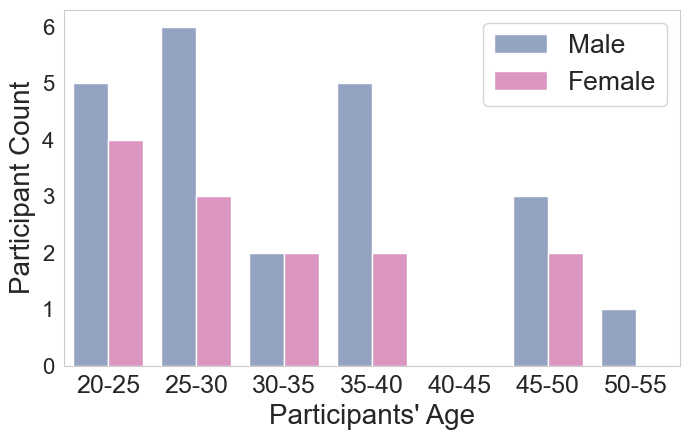

In [40]:
gender_age_data = pd.read_csv('../data/comfort/genderAge.csv')

# Bin the ages into groups to include the age of 20 and up to 55
age_bins = [20, 25, 30, 35, 40, 45, 50, 55]
gender_age_data['Age Group'] = pd.cut(gender_age_data['Age'], bins=age_bins, right=False)

plt.figure(figsize=(7, 4.5))
custom_palette = sns.color_palette("Set2")[2:4] # Use 3rd and 4th colors from the Set2 palette
sns.countplot(data=gender_age_data, x='Age Group', hue='Gender', palette=custom_palette)

plt.xlabel("Participants' Age", fontsize=20)
plt.ylabel('Participant Count', fontsize=20)
plt.xticks(ticks=range(len(age_bins)-1), labels=["20-25", "25-30", "30-35", "35-40", "40-45", "45-50", "50-55"], fontsize=18)
plt.yticks(fontsize=16)
plt.gca().yaxis.get_major_locator().set_params(integer=True)  # Ensure y-axis ticks are integers

# Modify legend to remove the title
plt.legend(title=None, fontsize=19, loc='upper right')
plt.grid(False) # Remove grid lines

plt.tight_layout()
plt.show()